In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import folium

## Uber Driver Segmentation

We have Uber GPS and timing information for each ride for New York City. It would be useful for Uber to be able to place drivers in an optimal location such that their time to pick up their next customer is minimized. If we are able to cluster areas within New York that have a higher density of rides, we can place drivers at the center of those hubs. 

We will use K-Means clusteirng to find these clusters. With regards to the business use-case, these clusters would be the zones and the centroids would be the hubs at which drivers would be placed. Hence, if the driver is at the hub, they are at an ideal location to reach any pick-up points within their zone.

## Import the Data

In [2]:
data = pd.read_csv('uber-raw-data-jul14.csv')

## Exploratory Data Analysis

In [3]:
data.head()

,Date/Time,Lat,Lon,Base
0,7/1/2014 0:03:00,40.7586,-73.9706,B02512
1,7/1/2014 0:05:00,40.7605,-73.9994,B02512
2,7/1/2014 0:06:00,40.7320,-73.9999,B02512
3,7/1/2014 0:09:00,40.7635,-73.9793,B02512
4,7/1/2014 0:20:00,40.7204,-74.0047,B02512


In [4]:
data.tail()

,Date/Time,Lat,Lon,Base
796116,7/31/2014 23:22:00,40.7285,-73.9846,B02764
796117,7/31/2014 23:23:00,40.7615,-73.9868,B02764
796118,7/31/2014 23:29:00,40.6770,-73.9515,B02764
796119,7/31/2014 23:30:00,40.7225,-74.0038,B02764
796120,7/31/2014 23:58:00,40.7199,-73.9884,B02764


The first ride is on July 1, and the last ride is on July 31. Hence, we have data from July 1 - July 31, 2014. 

In [5]:
data.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

We have four columns here which seem to be:
* Date/Time: Date and time of the pickup
* Lat: Latitude of pickup
* Lon: Longitude of pickup
* Base: TLC base company affiliated

In [6]:
data.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [7]:
data.describe()

,Lat,Lon
count,796121.000000,796121.000000
mean,40.739141,-73.972353
std,0.040551,0.058660
min,39.721400,-74.826000
25%,40.720900,-73.996100
50%,40.742500,-73.983200
75%,40.760800,-73.965100
max,41.341300,-72.309700


In [8]:
data.shape

(796121, 4)

We have 796121 records; hence, we have plenty of data.

In [9]:
data.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

We have no missing values in this dataset.

## Data Preprocessing

We want to create these clusters based on the longitude and latitude so we can drop the Date/Time and Base columns.

In [10]:
data.drop(columns=['Date/Time', 'Base'], inplace=True)

data.head()

,Lat,Lon
0,40.7586,-73.9706
1,40.7605,-73.9994
2,40.7320,-73.9999
3,40.7635,-73.9793
4,40.7204,-74.0047


We do not need to normalize our data here since longitude and latitude already represent distance and are on the same scale.

## K-Means 

### Elbow Method

We use the elbow method to determine our optimal number of clusters.

In [11]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

sse = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

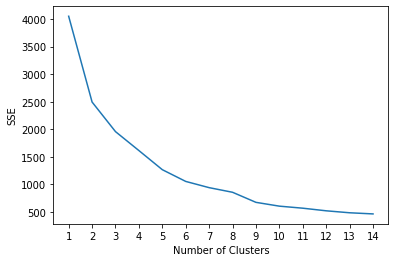

In [13]:
plt.plot(range(1,15), sse)
plt.xticks(range(1,15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

We are visually going to find the elbow using the plot above. Hence, let k = 7.

In [14]:
kmeans = KMeans(init="random",
               n_clusters=7,
               n_init=10,
               max_iter=300,
               random_state=42)

kmeans.fit(data)

KMeans(init='random', n_clusters=7, random_state=42)

In [15]:
# Lowest SSE value
kmeans.inertia_

942.4824296996043

In [16]:
# Final locations of centroids
centroids = kmeans.cluster_centers_
centroids

array([[ 40.6875284 , -73.96515326],
       [ 40.9094483 , -73.86254647],
       [ 40.73127427, -73.99792957],
       [ 40.66428666, -73.75688295],
       [ 40.7666428 , -73.97228751],
       [ 40.69813179, -74.20406049],
       [ 40.76320599, -73.87521369]])

In [17]:
# Number of iterations to converge
kmeans.n_iter_

13

In [18]:
kmeans.labels_

array([4, 4, 2, ..., 0, 2, 2], dtype=int32)

In [19]:
len(kmeans.labels_)

796121

In [20]:
freq = pd.DataFrame(kmeans.labels_).value_counts()
freq

2    328442
4    293893
0    101234
6     32134
3     25729
5      7694
1      6995
dtype: int64

These are the labels, i.e. cluster 0,1,2,3,4,5. We can see the distribution within our data based on which cluster these data points were categorized as. 

<BarContainer object of 7 artists>

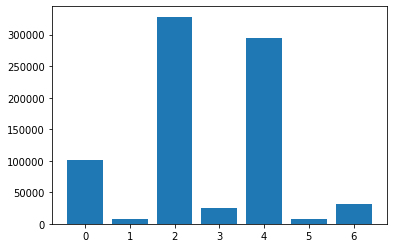

In [21]:
x = [2,4,0,6,3,5,1]
plt.bar(x, freq.values)

We can see that the majority of the rides are in cluster 2 and then 4. These are the popular areas in New York so we could place more drivers in these regions so they can get matched with more rides.

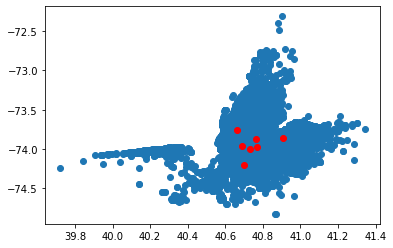

In [22]:
# Scatter plot with centroids in red
plt.scatter(data.Lat, data.Lon)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='red')

Quick visualization of our data points and where the centroids are. You can see that they are more towards the middle of the data. We want to visualize these centroids on google maps to get a better understanding of the placement of these hubs.

In [31]:
# Visualize our locations
locations = pd.DataFrame(centroids)
locations.columns = ['Latitude', 'Longitude']
locations.head()

,Latitude,Longitude
0,40.687528,-73.965153
1,40.909448,-73.862546
2,40.731274,-73.997930
3,40.664287,-73.756883
4,40.766643,-73.972288


In [33]:
# Plotting the centroids on google map using Folium library.
centroid = locations.values.tolist()
map = folium.Map(location=[40.79658011772687, -73.87341741832425], zoom_start = 25)
for point in range(0, len(centroid)):
    folium.Marker(centroid[point], popup = point).add_to(map)
map

Notice that regions 4 and 2 are in Manhattan, which would make sense as to why they are the busier regions with more trips. 

## Predict 

Let's see which hub a new ride would be in based on our clusters.

In [ ]:
new_location = [(40.5943, -73.8573)]
kmeans.predict(new_location)

Hence, we would be in the third region so if this was a new ride, a driver in the third region hub would be in close proximity to this pick-up.

## Business Value
* Can use these centroids as their region hubs so drivers in each region can go to these hubs so they are as close as possible to the majority of rides 
* Can place drivers in the regions that have a higher density of rides so they are getting matched more frequently
* Can find these centroids based on seasonality (hourly, daily, monthly)
    * Are the centroids different during rush hour?
    * Are the centroids different during weekends?
    * Are the centroids different during summer holidays vs. the remainder of the year? Christmas holidays? Etc. 